In [32]:
%%capture
%load_ext autoreload
%autoreload 2
# %cd ..
import sys
sys.path.append("..")
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

# Language Models

## Language Models

* calculate the probability of seeing a sequence of words. 
* For example: how likely is the following sequence?

> We're going to win bigly. 

## Use Cases:

* To filter out bad translations in machine translation.
    * For **"Wir werden haushoch gewinnen"**, LM compares 
        * We will win by a mile
        * We will win bigly
* To rank speech recognition output. 
    * **What did he say?**
        * We're going to win bigly
        * We're going to win big league
* More?

## Formally
* stochastic process that models the probability \\(\prob(w_1,\ldots,w_d)\\) of observing sequences of words \\(w_1,\ldots,w_d\\). 

* Without loss of generality: 

\begin{align}
\prob(w_1,\ldots,w_d) &= p(w_1) p(w_2|w_1) p(w_3|w_1, w_2) \ldots \\
 &= \prob(w_1) \prod_{i = 2}^d \prob(w_i|w_1,\ldots,w_{i-1})
\end{align}

* **Structured Prediction**: predict word $y=w_i$ conditioned on history $\x=w_1,\ldots,w_{i-1}$.

## A Uniform Baseline LM

* *Unigram* models: conditional probability is prior probability of seeing that word:
$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \prob(w_i).
$$

* The simplest case: *uniform* language model, same probability for each word in a *vocabulary* \\(\vocab\\):

$$
\prob(w_i|w_1,\ldots,w_{i-1}) = \frac{1}{|\vocab|}.
$$

Let us look at a training set and create a uniform LM from it.

In [33]:
train[:10]

['[BAR]', 'Can', "'t", 'even', 'call', 'this', 'a', 'blues', 'song', '[/BAR]']

In [34]:
vocab = set(train)
baseline = UniformLM(vocab)
baseline.probability("call")

0.0002913752913752914

What about other words? Summing up probabilities?

## Sampling
* Sampling from an LM is easy and instructive
* Usually, the better the LM, the better the samples

In [35]:
sample(baseline, [], 10)

['sane',
 'job',
 'wop',
 'rather',
 'listening',
 'super',
 'Letting',
 'eighty-five',
 'makes',
 'diary']

## Evaluation
* **Extrinsic**: how it improves a downstream task?
* **Intrinsic**: how good does it model language?

## Intrinsic Evaluation
* *Shannon Game*: Predict next word, win if prediction match words in actual corpus. 
* Formalised through **perplexity** of the LM on a given dataset. 

* Given test sequence \\(w_1,\ldots,w_T\\), perplexity \\(\perplexity\\) is **harmonic mean of inverse probabilities**:

\begin{align}
\perplexity(w_1,\ldots,w_T) &= \sqrt[T]{\frac{1}{\prob(w_1)} \frac{1}{\prob(w_2|w_1)} \ldots} \\
&= \sqrt[T]{\prod_i^T \frac{1}{\prob(w_i|w_{i-n},\ldots,w_{i-1})}}
\end{align}

* Interpretation: average number of choices

Perplexity of uniform LM on a test set?

In [36]:
perplexity(baseline, test)  

inf

The problem in the above example is that the baseline model assigns zero probability to words that are not in the vocabulary. 

In [37]:
[(w,baseline.probability(w)) for w in test if w not in vocab][:3]

[('does', 0.0), ('Ceremonies', 0.0), ('Masquerading', 0.0)]

## The Long Tail
New words not specific to our corpus: 
* long **tail** of words that appear only a few times
* each has low probability, but probability of seeing any long tail word is high


Let us plot word frequency ranks (x-axis) against frequency (y-axis) 

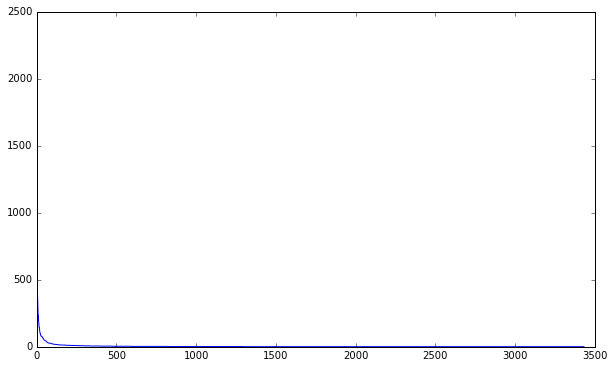

In [38]:
plt.xscale('linear')
plt.yscale('linear')
plt.plot(ranks, sorted_counts)

* In log-space such rank vs frequency graphs are linear 
* Known as **Zipf's Law**
* Let \\(r\_w\\) be the rank of a word \\(w\\), and \\(f\_w\\) its frequency:

$$
  f_w \propto \frac{1}{r_w}.
$$

* Also true in [random text](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.164.8422&rep=rep1&type=pdf)

## Inserting Out-of-Vocabularly Tokens
There will always be words with zero counts in your training set.

Solutions:
* Remove unseen words from test set (bad)
* Move probability mass to unseen words (good, discuss later)
* Replace unseen words with out-of-vocabularly token, estimate its probability

In [39]:
replace_OOVs(baseline.vocab, test[:10])

['[BAR]',
 'scratched',
 '[/BAR]',
 '[BAR]',
 'What',
 '[OOV]',
 'it',
 'take',
 '[/BAR]',
 '[BAR]']

Heuristically estimate the `OOV` probability:
* replace the first encounter of each word in the training set with the `OOV` token
* train language model on replaced data

In [40]:
inject_OOVs(["AA","AA","BB","BB","AA"])

['[OOV]', 'AA', '[OOV]', 'BB', 'AA']

In [41]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
oov_baseline = UniformLM(oov_vocab)
perplexity(oov_baseline,oov_test) 

1290.0000000049852

What does this perplexity correspond to?

## Training Language Models
* Uniform LM is not good at modeling language 
* Better: estimate how likely $w$ given $h$ is based on training data 
* Introduce parameter $\param_{w,h}$ for word $w$ history $h$ 
* Define a parametrized language model $p_\params$: 

$$
\prob_\params(w|h) = \param_{w,h}
$$

* Training amounts to estimating \\(\params\\) from training set \\(\train=(w_1,\ldots,w_n)\\).
* One way: choose \\(\params\\) that maximizes the log-likelihood of \\(\train\\):
$$
\params^* = \argmax_\params \log p_\params(\train)
$$
* **Structured Prediction**: continuous optimization problem with (neg.) loss 

* Maximum-log-likelihood estimate (MLE) can be calculated in [closed form](notebooks/chapters/mle.ipynb):
$$
\prob_{\params^*}(w|h) = \param^*_{w,h} = \frac{\counts{\train}{h,w}}{\counts{\train}{h}} 
$$

where 

$$
\counts{D}{e} = \text{Count of } e \text{ in }  D 
$$

* Many LM variants: different estimation of counts. 

## Unigram Model
Let us train a unigram model with $n=1$

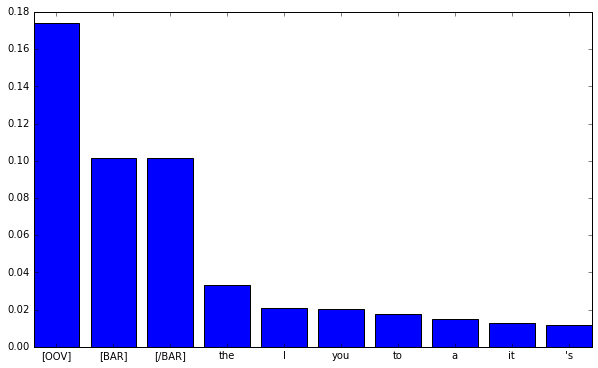

In [42]:
unigram = NGramLM(oov_train,1)
plot_probabilities(unigram)

The unigram LM has substantially reduced (and hence better) perplexity:

In [43]:
perplexity(unigram,oov_test) 

91.4414922652717

Its samples look (a little) more reasonable:

In [59]:
sample(unigram, [], 10)

['for',
 'be',
 '[OOV]',
 'the',
 'live',
 '[OOV]',
 'it',
 'PEACE',
 '[OOV]',
 'better']

## Bigram Model
We can do better by setting $n=2$

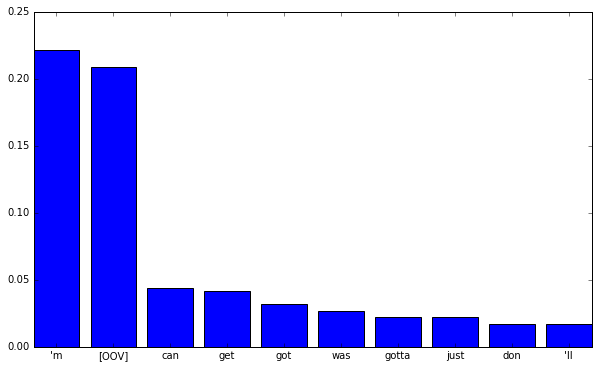

In [45]:
bigram = NGramLM(oov_train,2)
plot_probabilities(bigram, ('I',))

Samples should look (slightly) more fluent:

In [46]:
" ".join(sample(bigram, ['[BAR]'], 30))

"[BAR] No matter [/BAR] [BAR] Just deal with a bird 's just a [OOV] to be [OOV] too different [OOV] how hip-hop was [OOV] [/BAR] [BAR] [OOV] to [OOV] dope rhymes"

How about perplexity?

In [47]:
perplexity(bigram,oov_test) 

inf

There are contexts in which the OOV word (and other words) hasn't been seen, and hence it receives 0 probability.

In [48]:
bigram.probability("[OOV]","money") 

0.0

## Smoothing

* maximum likelhood underestimates true probability of some words, and overestimates the probabilities of other. 
* Solution: _smooth_ the probabilities and move mass from seen to unseen events.

### Laplace Smoothing

* add pseudo counts to each event in the dataset 
* Bayesian view: maximum posteriori estimate under a dirichlet prior on parameters.

$$
\param^{\alpha}_{w,h} = \frac{\counts{\train}{h,w} + \alpha}{\counts{\train}{h} + \alpha \lvert V \rvert } 
$$

In [49]:
laplace_bigram = LaplaceLM(bigram, 0.1) 
laplace_bigram.probability("[OOV]","money")

0.0007692307692307692

Perplexity should look better now:

In [50]:
perplexity(laplace_bigram,oov_test) 

72.41090509288753

### Adjusting Counts
* Reformulate smoothing as changing counts but keep total mass (denominator) constant

|word|train count | MLE | Laplace | Adjusted |
|------------|------------
| smally| 0 | $\frac{0}{3}$ | $\frac{0+1}{3+3}$ $=\frac{1}{6}$ | $\frac{0.5}{3}$ |
| bigly| 1 | $\frac{1}{3}$ | $\frac{1+1}{3+3}$ $=\frac{2}{6}$ | $\frac{1.0}{3}$ |
| tremendously| 2 | $\frac{2}{3}$ | $\frac{2+1}{3+3}$ $=\frac{3}{6}$ | $\frac{1.5}{3}$ |

* Allows you to compare the effect of different smoothing techniques 

In [51]:
pd.DataFrame(frame, columns = ["Train Count", "Test Count", "Smoothed Count"])

,Train Count,Test Count,Smoothed Count
0,0,0.003375,0.004950
1,1,0.437487,0.301893
2,2,1.115207,0.754602
3,3,1.661538,1.212537
4,4,2.675325,1.572842
5,5,4.101852,2.280637
6,6,4.688312,2.562516
7,7,5.392857,3.577428


* Test counts usually between 0.6 and 1.4 smaller than train counts
* In larger datasets even more consistent
* Useful for smoothing? See [exercise](../exercises/language_models.ipynb)!  

### Interpolation
Laplace Smoothing shifts mass uniformly across the words that haven't been seen.

In [66]:
laplace_bigram.probability('skies','skies'), laplace_bigram.probability('[/BAR]','skies')

(0.0007633587786259542, 0.0007633587786259542)

We can do better: 
* give more mass to words likely under the $n-1$-gram model. 
    * Use $\prob(\text{skies})$ for estimating $\prob(\text{skies}|\text{skies})$
* Combine $n$-gram model \\(p'\\) and a back-off \\(n-1\\) model \\(p''\\): 

$$
\prob_{\alpha}(w_i|w_{i-n},\ldots,w_{i-1}) = \alpha \cdot \prob'(w_i|w_{i-n},\ldots,w_{i-1}) + \\ (1 - \alpha) \cdot \prob''(w_i|w_{i-n+1},\ldots,w_{i-1})
$$


In [62]:
interpolated = InterpolatedLM(bigram,unigram,0.01)
interpolated.probability('skies','skies'), interpolated.probability('[/BAR]','skies')

(0.00010054844606946984, 0.10059872029250458)

Can we find a good $\alpha$ parameter? Tune on some dev set!

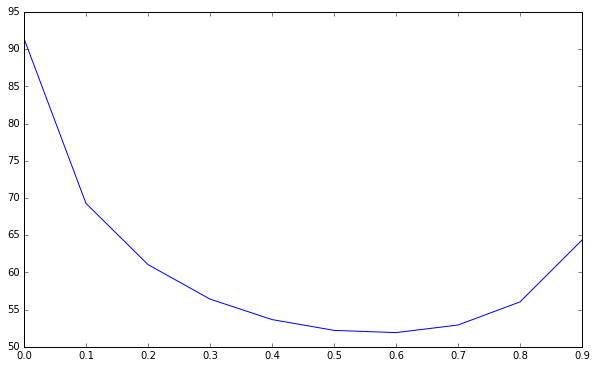

In [61]:
alphas = np.arange(0,1.1,0.1)
perplexities = [perplexity(InterpolatedLM(bigram,unigram,alpha),oov_test) for alpha in alphas]
plt.plot(alphas,perplexities)

### Backoff 
* rely on available counts where possible. 
* back-off only when no counts for a given event are available.

### Stupid Backoff
Let \\(w\\) be a word and \\(h_{n}\\) an n-gram of length \\(n\\):  

$$
\prob_{\mbox{Stupid}}(w|h_n) = 
\begin{cases}
\frac{\counts{\train}{h_n,w}}{\counts{\train}{h_n}}  &= \mbox{if }\counts{\train}{h_n,w} > 0 \\\\
\prob_{\mbox{Stupid}}(w|h_{n-1}) & \mbox{otherwise}
\end{cases}
$$

What is the problem with this model?

In [55]:
stupid = StupidBackoff(bigram, unigram, 0.1)
sum([stupid.probability(word, 'the') for word in stupid.vocab])

1.0647115579930915

"proper backoff models" do not have this problem, e.g. the Katz-Backoff method. See external material for a deeper discussion of these.

### Background Reading

* Jurafsky & Martin, Speech and Language Processing: Chapter 4, N-Grams.
* Bill MacCartney, Stanford NLP Lunch Tutorial: [Smoothing](http://nlp.stanford.edu/~wcmac/papers/20050421-smoothing-tutorial.pdf)